# Машинное обучение
## ВМК МГУ, весна 2015/2016
## Лабораторная работа 1. Линейные модели

ФИО: Шолохова Татьяна Николаевна

Группа: 317

Данное задание посвящено применению линейных моделей в задачах классификации и регрессии. Вы научитесь:
* делать one-hot-кодирование категориальных признаков
* обучать логистическую и линейную регрессию
* отбирать признаки с помощью LASSO
* вычислять метрики качества классификации и регрессии
* выбирать лучший классификатор при ограничениях на точность или полноту
* калибровать вероятности
* реализовывать градиентный спуск (если захотите)


In [256]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Часть 1. Научные гранты в Австралии

![](http://imgur.com/cBdDBO3.jpg)

В данной части мы будем работать с задачей "Predict Grant Applications" (https://www.kaggle.com/c/unimelb/data), где для заявки на грант требуется предсказать, одобрят её или нет. Будем использовать лишь 40 признаков из имеющихся 249. Файлы для работы можно найти по ссылкам:
* https://db.tt/iYzRzQYP (обучение)
* https://db.tt/NGSHb5Qs (контроль)

#### Задание 1
Считайте обучающую и контрольную выборки из файлов с помощью pd.read_csv. Выделите целевую переменную (Grant.Status) в отдельный вектор.

In [113]:
data_train = pd.read_csv('unimel_train.csv')
data_test = pd.read_csv('unimel_test.csv')
y = np.array(data_train['Grant.Status'])
y_test = np.array(data_test['Grant.Status'])
del data_train['Grant.Status']
del data_test['Grant.Status']

#### Задание 2
В этом задании мы приведем данные к виду, пригодному для обучения линейных классификаторов. Для этого вещественные признаки надо отмасштабировать, а категориальные — привести к числовому виду. Также надо устранить пропуски в данных.

В первую очередь поймем, зачем здесь нужно масштабирование. Нарисуем распределение трех признаков.

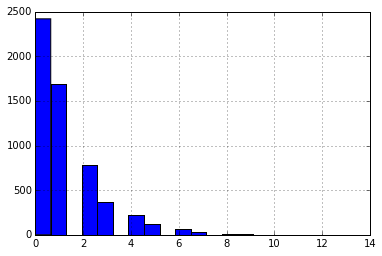

In [3]:
data_train['Number.of.Successful.Grant.1'].hist(bins=20)

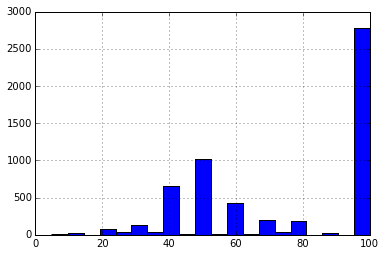

In [4]:
data_train['RFCD.Percentage.1'].hist(bins=20)

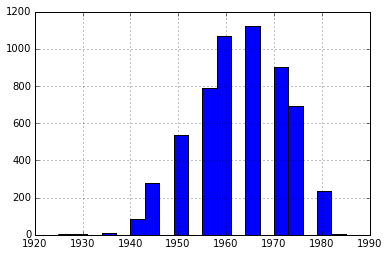

In [5]:
data_train['Year.of.Birth.1'].hist(bins=20)

Какую проблему вы наблюдаете на этих графиках? ***Данные не нормированы(значения первого признако не превышает 14, когда третий признак лежит в интервале [1920, 1990].*** Как масштабирование поможет её исправить? ***Ненормированность признаков влиет на веса линейных методов, которые в свою очередь влияют на скорость содимости метода оптимизации. Масштобирование ускорит скорость сходимости.***

В наших данных есть пропуски. Ответьте на вопросы:
1. Сколько всего пропущенных элементов в таблице с обучающей выборкой? ***26843***
2. Сколько объектов имеют хотя бы один пропуск? ***5879***
3. Сколько признаков имеют хотя бы одно пропущенное значение? ***38***

In [6]:
print '1. ', np.sum(np.sum(data_train.isnull()))
print '2. ', np.sum(np.sum(data_train.isnull(), axis = 1) != 0)
print '3. ', np.sum(np.sum(data_train.isnull()) != 0) 

1.  26843
2.  5879
3.  38


Большинство признаков в нашем датасете являются категориальными. Типичным подходом к работе с ними является бинарное, или one-hot-кодирование (также есть подход со счётчиками, который мы уже применяли в прошлых работах). Для начала потренируемся делать бинарное кодирование на трех игрушечных объектах.

In [7]:
simple_data = pd.DataFrame({'City': ['Msk', 'SPb', 'Msk'], 'Weather': ['good', 'bad', 'worst']})
simple_data.head()

,City,Weather
0,Msk,good
1,SPb,bad
2,Msk,worst


In [8]:
# преобразуем каждый объект в dict
simple_data_dict = simple_data.T.to_dict().values()
print simple_data_dict

[{'City': 'Msk', 'Weather': 'good'}, {'City': 'SPb', 'Weather': 'bad'}, {'City': 'Msk', 'Weather': 'worst'}]


In [9]:
# делаем one-hot-кодирование
from sklearn.feature_extraction import DictVectorizer
transformer = DictVectorizer(sparse=False)
# примените здесь DictVectorizer к simple_data_dict, получите бинарную матрицу и выведите её
bin_matrix = transformer.fit_transform(simple_data_dict)
print bin_matrix

[[ 1.  0.  0.  1.  0.]
 [ 0.  1.  1.  0.  0.]
 [ 1.  0.  0.  0.  1.]]


Реализуйте функцию transform_data, которая принимает на вход DataFrame с признаками, объекты классов StandardScaler и DictVectorizer и булеву переменную is_test (True, если обрабатывает тестовую выборку и False, если обучающую). В функции должны выполняться следующие шаги:
1. Замена пропущенных значений на нули для вещественных признаков и на строки 'nan' для категориальных. Используйте для выполнения замены функцию fillna. Имена всех вещественных переменных перечислены в numeric_cols.
2. Масштабирование вещественных признаков с помощью StandardScaler (метод fit_transform, если is_test == False, и метод transform в противном случае).
3. One-hot-кодирование категориальных признаков с помощью DictVectorizer (метод fit_transform, если is_test == False, и метод transform в противном случае).

Метод должен возвращать tuple из трех элементов: преобразованной выборки, объекта StandardScaler и объекта DictVectorizer. Преобразованная выборка должна состоять из масштабированных вещественных признаков и закодированных категориальных (исходные признаки не должны в ней остаться).

In [252]:
def transform_data(data, scaler, transformer, is_test):
    numeric_cols = ['RFCD.Percentage.1', 'RFCD.Percentage.2', 'RFCD.Percentage.3', 
                    'RFCD.Percentage.4', 'RFCD.Percentage.5',
                    'SEO.Percentage.1', 'SEO.Percentage.2', 'SEO.Percentage.3',
                    'SEO.Percentage.4', 'SEO.Percentage.5',
                    'Year.of.Birth.1', 'Number.of.Successful.Grant.1', 'Number.of.Unsuccessful.Grant.1']
    data1 = data[numeric_cols].fillna(0)
    features = list(data.columns)
    categorial_cols = list(set(features) - set(numeric_cols)) 
    data2 = data[categorial_cols].fillna('nan')
    data2 = data2.astype(str)
    data2 = data2.T.to_dict().values()
    if is_test:
        if scaler != None:
            data1 = scaler.transform(data1)
        data2 = transformer.transform(data2)
    else:
        if scaler != None:
            data1 = scaler.fit_transform(data1)
        data2 = transformer.fit_transform(data2)
    
    data1 = np.array(data1)
    data2 = np.array(data2)
    
    return (np.hstack((data1, data2)), scaler, transformer)

Применяем функцию к данным:

In [106]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
transformer = DictVectorizer(sparse=False)
X, scaler, transformer = transform_data(data_train, scaler, transformer, False)
X_test, _, _ = transform_data(data_test, scaler, transformer, True)

Сколько признаков у вас получилось после преобразования? ***11734***

In [12]:
print X.shape[1]

11734


#### Задание 3
Подберите лучшее значение параметра регуляризации C для логистической регрессии с L2-регуляризатором (sklearn.linear_model.LogisticRegression) с помощью кросс-валидации по 5 блокам. В качестве метрики качества используйте AUC-ROC. Сетка для перебора указана ниже. По итогам кросс-валидации укажите лучшее значение параметра регуляризации. Обучите классификатор с этим параметром на всей обучающей выборке и найдите качество (AUC-ROC) на тестовой выборке.
***AUC-ROC $= 0.88$, лучшее значение параметра регуяризации $0.1$***

In [13]:
from sklearn.cross_validation import KFold
cv = KFold(X.shape[0], n_folds=5, shuffle=True, random_state=241)

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import roc_auc_score
def scorer(estimator, X, y):
    proba = estimator.predict_proba(X)[:, 1]
    return roc_auc_score(y, proba)
    
# вам пригодятся функции cross_val_score или GridSearchCV; используйте в них объект cv в качестве генератора разбиений
C_grid = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
logistic = LogisticRegression()
C_dict = {'C' : C_grid}
search = GridSearchCV(logistic, C_dict, scorer, verbose = 1, cv=cv)
search.fit(X, y)
print search.best_params_['C']


[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   28.0s finished


Fitting 5 folds for each of 6 candidates, totalling 30 fits
0.1


In [15]:
print scorer(search, X_test, y_test)

0.880344342415


Попробуем теперь логистическую регрессию с L1-регуляризатором (penalty='l1'). Выведите число ненулевых коэффициентов (clf.coef\_) при каждом значении параметра регуляризации из сетки.

In [21]:
for C in C_grid:
    clf = LogisticRegression(penalty='l1', C = C)
    clf.fit(X, y)
    coef = np.array(clf.coef_)
    print C, np.sum(np.abs(coef) > 1e-7)

0.001 0
0.01 9
0.1 58
1.0 667
10.0 2462
100.0 2861


Какое качество на тесте даёт логистическая регрессия с L1-регуляризатором с параметром C=0.01? ***ROC-AUC = 0.85*** Сколько для достижения такого качества ей нужно признаков? ***9 признаков***

In [27]:
clf = LogisticRegression(penalty='l1', C = 0.01)
clf.fit(X, y)
coef = np.array(clf.coef_)
print scorer(clf, X_test, y_test)
print 0.01, np.sum(np.abs(coef) > 1e-7)

0.85254615488
0.01 9


#### Задание 4
В этом задании мы внимательно рассмотрим различные аспекты качества классификатора. Для этого возьмите классификатор с L2-регуляризатором с лучшим значением параметра регуляризации (вы его нашли в предыдущем задании), обучите на полной обучающей выборке и найдите предсказания вероятностей на тесте. Далее будем работать только с этими прогнозами.

In [37]:
clf = LogisticRegression(C = 0.1)
clf.fit(X, y)
proba = clf.predict_proba(X_test)[:, 1]

[ 0.91309593  0.11992903  0.55759463 ...,  0.89345704  0.07434108
  0.09623146]


Посчитайте AUC-ROC, AUC-PR (average_precision_score) и log-loss для прогнозов.

In [38]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import log_loss

print 'AUC-ROC', roc_auc_score(y_test, proba)
print 'AUC-PR', average_precision_score(y_test, proba)
print 'log-loss', log_loss(y_test, proba)

AUC-ROC 0.880344342415
AUC-PR 0.838753258274
log-loss 0.44273695579


Нарисуйте ROC- и PR-кривые. Не забудьте подписать оси.

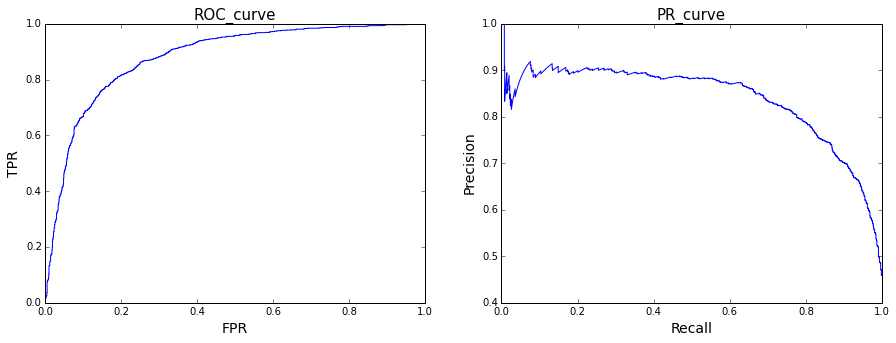

In [62]:
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
ROCcurve = roc_curve(y_test, proba)
PRcurve = precision_recall_curve(y_test, proba)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(ROCcurve[0], ROCcurve[1])
axes[0].set_xlabel('FPR', fontsize=14)
axes[0].set_ylabel('TPR', fontsize=14)
axes[0].set_title('ROC_curve', fontsize=15)

axes[1].plot(PRcurve[1], PRcurve[0])
axes[1].set_xlabel('Recall', fontsize=14)
axes[1].set_ylabel('Precision', fontsize=14)
axes[1].set_title('PR_curve', fontsize=15)

plt.show()

Допустим, мы хотим построить классификатор, который будет находить не менее 90% успешных грантов. Соответственно, имеем нижнюю границу 90% на полноту. Какую максимальную точность при этом можно получить? ***Максимальная точность = 0.7*** При каком значении порога? ***Порог = 0.31*** Для получения ответа проанализируйте массивы, возвращаемые функцией metrics.precision_recall_curve.

In [76]:
precision = PRcurve[0][1:]
recall = PRcurve[1][1:]
thresholds = PRcurve[2]
mask = recall >= 0.9
m = np.argmax(precision[mask])

print 'precision = ', precision[mask][m]
print 'threshold =', thresholds[mask][m]

precision =  0.701948051948
threshold = 0.314404979253


Возьмите классификатор с порогом из предыдущего пункта и подсчитайте для него F-меру. ***F-мера$= 0.79$.  ***Почему она получилась маленькой, несмотря на высокую полноту? ***Из-за невысокой точности*** 

In [79]:
F = 2 * precision[mask][m] * recall[mask][m] / (precision[mask][m] + recall[mask][m]) 
print 'F-measure = ', F

F-measure =  0.7887632251


Допустим, что университету важно подавать как можно меньше заявок, которые окажутся неуспешными — они очень плохо влияют на репутацию. Установим нижнюю границу на точность 80%. Какую максимальную полноту при этом можно обеспечить? При каком пороге?
***Максимальная полнота достигается при пороге 0.528 и равна 0.776***

In [82]:
mask2 = precision >= 0.8
m2 = np.argmax(recall[mask2])

print 'recall = ', recall[mask2][m2]
print 'threshold =', thresholds[mask2][m2]

recall =  0.776019983347
threshold = 0.528452621358


#### Задание 5
В этом задании мы научимся оценивать способность классификатора предсказывать вероятности, а также разберемся с калибровкой.

Начнем с калибровочных кривых. Допустим, алгоритм возвращает некоторые числа от нуля до единицы. Хорошо ли они оценивают вероятность? Для этого разобьем отрезок $[0, 1]$ на несколько маленьких отрезков одинаковой длины. Рассмотрим $i$-й отрезок с границами $[a_i, b_i]$ и предсказания $p_1, p_2, \dots, p_k$, которые попали в него. Пусть им соответствуют истинные ответы $y_1, y_2, \dots, y_k$. Если алгоритм выдает корректные вероятности, то среди этих истинных ответов должно быть примерно $(a_i + b_i) / 2$ единиц. Иными словами, если нарисовать кривую, у которой по оси X отложены центры отрезков, а по оси Y — доли единичных ответов этих в отрезках, то она должна оказаться диагональной. Ниже приведена функция, которая должна рисовать такие кривые. В ней допущено две ошибки — найдите и исправьте их.

In [87]:
def plot_calibration_curve(y_test, preds):
    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 20
    for i in range(n_bins):
        l = 1.0 / n_bins * i
        r = 1.0 / n_bins * (i + 1)
        bin_middle_points.append((r + l) / 2)
        bin_real_ratios.append(np.mean(y_test[(preds >= l) & (preds < r)] == 1))
    plt.plot(bin_middle_points, bin_real_ratios)

Проверим её работу на логистической регрессии (поменяйте имена переменных, если это необходимо). Получилась ли почти диагональная калибровочная кривая? ***Да, кривая похожа на диагональную***

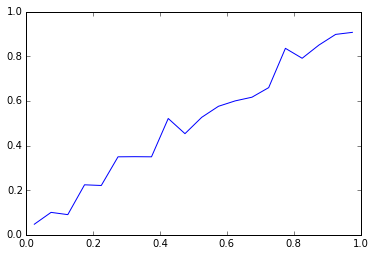

In [88]:
clf = LogisticRegression(C=1.0)
clf.fit(X, y)
preds = clf.predict_proba(X_test)[:, 1]
plot_calibration_curve(y_test, preds)

Заодно обратим внимание на то, как часто классификатор выдает те или иные вероятности.

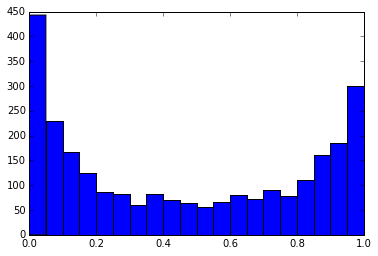

In [89]:
plt.hist(preds, bins=20)
plt.show()

Обучим теперь классификатор с кусочно-линейной функцией потерь (hinge loss, как в SVM).

In [91]:
from sklearn.linear_model import SGDClassifier
clf = SGDClassifier(loss='hinge')
clf.fit(X, y)
preds = clf.decision_function(X_test)
preds = 1.0 / (1.0 + np.exp(-preds))

Изучите распределение ответов классификатора. Чем оно отличается от распределения у логистической регрессии? ***Классификатор с кусочно-линейной функцией потерь ещё чаще предсказывает вероятности 0.0 и 1.0.*** Чем вы можете объяснить это? ***Классификатор с логистической функцией потерь предсказывает вероятности, а классификатор с кусочно-линейной функцией потерь разделяет классы.***

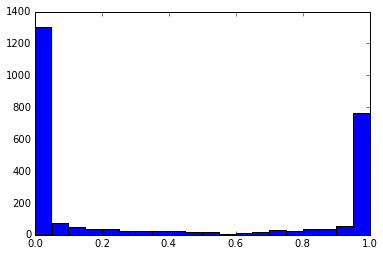

In [92]:
plt.hist(preds, bins=20)
plt.show()

Нарисуем калибровочную кривую. Видите ли вы какие-либо проблемы в ней? ***Она не диагональная***

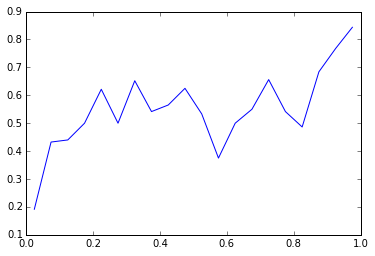

In [94]:
plot_calibration_curve(y_test, preds)

Попробуем откалибровать вероятности. Грубо говоря, это процедура, которая для каждого отрезка $[a_i, b_i]$ строит преобразование, которое корректирует вероятности в нем, приводя тем самым калибровочную кривую к диагональной форме.

Воспользуйтесь классом sklearn.calibration.CalibratedClassifierCV для калибровки вероятностей на обучении, и постройте с его помощью предсказания для тестовой выборки. Нарисуйте для них калибровочную кривую. Улучшилась ли она? ***Да, кривая стала более диагональной***

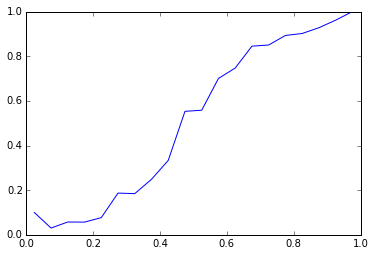

In [101]:
from sklearn.calibration import CalibratedClassifierCV
clf = CalibratedClassifierCV(SGDClassifier(loss='hinge'))
clf.fit(X, y)
preds = clf.predict_proba(X_test)[:, 1]
plot_calibration_curve(y_test, preds)

#### Задание 6
Здесь вы можете вставить вашу любимую картинку про Австралию.

<img src="http://basik.ru/images/baby_echidnas/03_echidnas.jpg" width=350>

## Часть 2. Градиентный спуск своими руками
**(опциональная часть, за правильное выполнение к оценке добавляется 3 балла)**

В этой части вам предстоит самостоятельно реализовать градиентный спуск для логистической функции потерь — то есть, по сути, собственными руками обучить логистическую регрессию. Будем использовать данные из предыдущей части.

Добавьте к обучающей и тестовой выборкам единичный признак. Переведите значения целевого вектора в множество $\{-1, +1\}$.

In [115]:
X2 = np.hstack((X, np.ones((X.shape[0], 1))))
X2_test = np.hstack((X_test, np.ones((X_test.shape[0], 1))))
y2 = 2*y - 1
y2_test = 2*y_test - 1

Для начала реализуйте функции, которые вычисляют функционал, его градиент, а также прогнозы модели.

In [126]:
from math import e
# возвращает вектор предсказанных вероятностей для выборки X
def make_pred(X, w):
    return 1 / (1 + e ** (-np.sum(X * w, axis=1)))

In [222]:
# возвращает значение логистического функционала для выборки (X, y) и вектора весов w
def get_func(w, X, y):
   return np.mean(np.log(1 + e ** (-y*(np.sum(X * w, axis=1)))))

In [223]:
# возвращает градиент логистического функционала для выборки (X, y) и вектора весов w
def get_grad(w, X, y):
    return -np.mean((X.T * y) / (1 + e ** np.sum(((X * w).T * y).T, axis = 1)), axis=1)

Теперь реализуйте градиентный спуск (не стохастический). Функция должна возвращать вектор весов и список значений функционала на каждой итерации. В градиентном спуске должно выполняться не более max_iter итераций.

In [230]:
def grad_descent(X, y, step_size, max_iter):
    eps = 1e-5 * step_size
    J = []
    w = np.random.normal(scale=0.1, size=X.shape[1])
    J.append(get_func(w, X, y))
    for i in range(max_iter):
        w_new = w - step_size * get_grad(w, X, y)
        J.append(get_func(w_new, X, y))
        if np.sum((w_new - w) ** 2) < eps:
            return (w_new, np.array(J))
        w = w_new
    return (w, np.array(J))

Запустите градиентный спуск для значений размера шага из набора [0.001, 1, 10]. Нарисуйте кривые зависимости значения функционала от номера итерации. Проанализируйте их. Вычислите AUC-ROC на тестовой выборке для лучшего из обученных вариантов.

***AUC-ROC = $0.8734$***

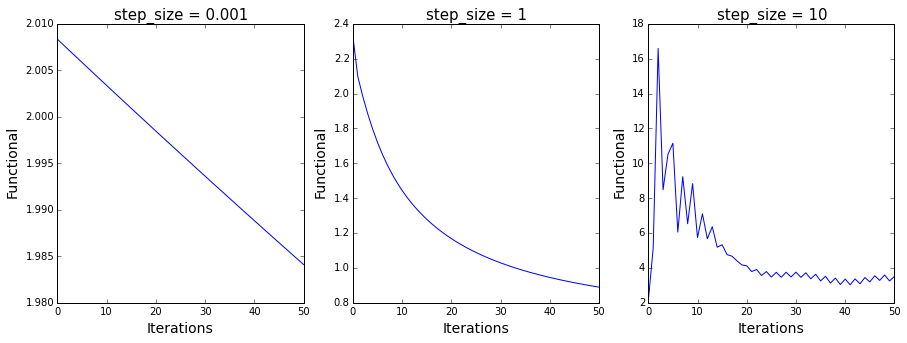

In [226]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
i = 0

for step in [0.001, 1, 10]:
    grad_res = grad_descent(X2, y2, step, 50)[1]
    iters = grad_res.shape[0]
    axes[i].plot(np.arange(iters), grad_res)
    axes[i].set_xlabel('Iterations', fontsize=14)
    axes[i].set_ylabel('Functional', fontsize=14)
    axes[i].set_title('step_size = ' + str(step), fontsize=15)
    i += 1

plt.show()

***По графикам зависимостей можно сделать следующие выводы:***
 * ***С шагом $0.001$ функционал сходится слишком медленно ***
 * ***С шагом $10$ наблюдаются большие скачки функционала, функционал не сходится *** 
 * ***Шаг $1$ оптимален в данном случае ***

In [231]:
w = grad_descent(X2, y2, 1, 200)[0]
preds = make_pred(X2_test, w)
print roc_auc_score(y2_test, preds)

0.873492757452


Теперь реализуйте стохастический градиентный спуск. Функция должна возвращать вектор весов и список значений функционала на каждой итерации. В стохастическом градиентном спуске должно выполняться не более max_iter итераций.

In [241]:
def sgd(X, y, step_size, max_iter):
    eps = 1e-5 * step_size
    J = []
    w = np.random.normal(scale=0.1, size=X.shape[1])
    J.append(get_func(w, X, y))
    for i in range(max_iter):
        ix = np.random.randint(0, X.shape[0]-1)
        w_new = w - step_size * get_grad(w, np.reshape(X[ix], (1, X.shape[1])), np.array([y[ix]]))
        J.append(get_func(w_new, X, y))
        if np.sum((w_new - w) ** 2) < eps:
            return (w_new, np.array(J))
        w = w_new
    return (w, np.array(J))

Подберите размер шага, при котором SGD будет сходиться. Нарисуйте график сходимости. Вычислите AUC-ROC на тестовой выборке. 

***AUC-ROC $= 0.8379$***

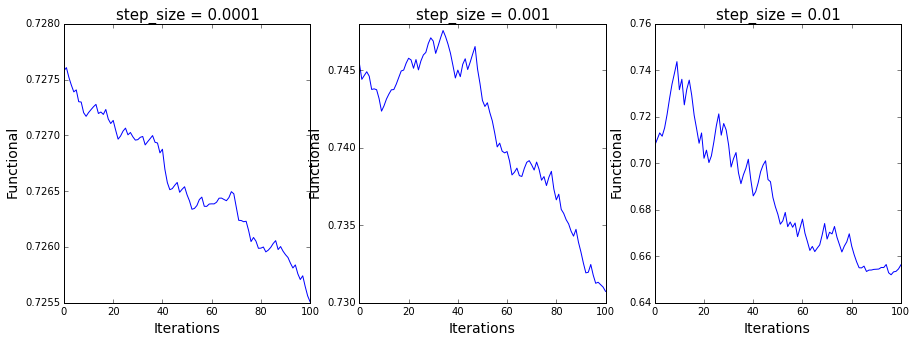

In [246]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
i = 0

for step in [0.0001, 0.001, 0.01]:
    grad_res = sgd(X2, y2, step, 100)[1]
    iters = grad_res.shape[0]
    axes[i].plot(np.arange(iters), grad_res)
    axes[i].set_xlabel('Iterations', fontsize=14)
    axes[i].set_ylabel('Functional', fontsize=14)
    axes[i].set_title('step_size = ' + str(step), fontsize=15)
    i += 1

plt.show()

In [253]:
w = sgd(X2, y2, 0.01, 2000)[0]
preds = make_pred(X2_test, w)
print roc_auc_score(y2_test, preds)

0.837979386866


А теперь самое сложное: заново сформируйте выборку с помощью transform_data, но теперь не масштабируйте вещественные признаки. Запустите на этой выборке градиентный спуск. Что вы наблюдаете? ***Точность сильно уменьшилась***Удается ли достичь такого же качества, как и при использовании масштабирования? ***Не удаётся***

In [257]:
X3, _, transformer = transform_data(data_train, None, transformer, False)
X3_test, _, _ = transform_data(data_test, None, transformer, True)
w = grad_descent(X3, y, 1, 200)[0]
preds = make_pred(X3_test, w)
print roc_auc_score(y_test, preds)

0.501390189479


Здесь вы можете поделиться своими мыслями по поводу этой части.

* ***важно масштабировать вещественные признаки для градиентного спуска с логистической функцией потерь***
* ***важно правильно выбрать шаг для градиентного спуска, для слишком больших или слишком маленьких шагов алгоритм расходится***
* ***стохастический градиентный спуск работает быстрее обычного градиентного спуска, но сходится медленнее и более нестабилен***

## Часть 3. Линейная регрессия на простом примере

В этой части мы очень кратко разберемся с линейной регрессией и измерением качества ее прогнозов. Будем использовать датасет diabetes.

In [258]:
from sklearn import datasets
from sklearn.cross_validation import train_test_split
data = datasets.load_diabetes()
X, X_test, y, y_test = train_test_split(data.data, data.target, train_size=0.7, random_state=241)

Обучите линейную регрессию с L2-регуляризатором, подобрав лучшее значение параметра регуляризации на тестовой выборке. Используйте MSE в качестве функционала качества. При каком значении этого параметра достигается наилучшее качество? ***alpha = $0.1$***

In [271]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
alpha_grid = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
for alpha in alpha_grid:
    clf = Ridge(alpha = alpha)
    clf.fit(X, y)
    z = clf.predict(X_test)
    MSE = mean_squared_error(y_test, z)
    print 'alpha = ', alpha
    print 'MSE = ', MSE

alpha =  0.001
MSE =  3120.09020578
alpha =  0.01
MSE =  3107.38818648
alpha =  0.1
MSE =  3096.03015101
alpha =  1.0
MSE =  3399.40482339
alpha =  10.0
MSE =  4577.48210429
alpha =  100.0
MSE =  5210.22019186


Вычислите для лучшей из моделей RMSE и коэффициент детерминации (r2_score) на тестовой выборке. Что вы можете сказать о значении коэффицинта детерминации? Насколько данная модель близка к оптимальной? *** У оптимальной модели коэффициент детерминизации равен $1$, можно сделать вывод, что данная модель достаточно долека от оптимальной. Она ближе к плохой модели(с коэффициентом детерминизации $0$), просто предсказывающей среднее. Скорее всего так происходит из-за неверного предположения о том, что ответы от признаков зависят линейно***

In [275]:
from sklearn.metrics import r2_score
from math import sqrt
clf = Ridge(alpha = 0.1)
clf.fit(X, y)
z = clf.predict(X_test)
RMSE = sqrt(mean_squared_error(y_test, z))
R2 = r2_score(y_test, z)
print 'alpha = ', 0.1
print 'RMSE = ', RMSE
print 'r2_score = ', R2


alpha =  0.1
RMSE =  55.6419819113
r2_score =  0.417024184822
